Para este punto, construimos un modelo para entrenar los datos de "train.csv" para luego poder predecir si "se fue" con los datos de "test.csv". 

Como primer paso importamos ambos CSV y creamos 2 DF distintos, luego procedemos a realizar un analisis para averiguar los tipos de datos y si se encontraban nulos o no. 

Despues de realizar y verificar que ambos DF estaban limpios y no presentaba outliers, procedimos a realizar un flujo de trabajo para que pueda ser reutilizable con pipeline y con un grid search para evaluar distintas alternativas. Para este caso, vamos a realizar un pipeline de 3 pasos, donde vamos a evaluar las features, luego vamos a normalizar los datos y por ultimo aplicamos un modelo llamado KNN, que es optimo para este tipo de analisis. 

Una vez realizado el pipeline, prodcedemos a preparar nuestro DF de test y lo predecimos. 

De los resultados obtenidos, creamos un DF y exportamos los resultados con el nombre de "Submission_Manuel_Nano.csv"



In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE



c:\Users\nanomanu\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Importamos los DF de train y test. 

ruta_train = r'C:\Users\nanomanu\Desktop\Evaluacion Tecnica Analista Sr - Consultor BDS\train.csv'
ruta_test = r'C:\Users\nanomanu\Desktop\Evaluacion Tecnica Analista Sr - Consultor BDS\test.csv'

df_train = pd.read_csv(ruta_train)
df_test = pd.read_csv(ruta_test)

display("Train:", df_train.head(3))
print('Este Dataset tiene', df_train.shape[0], 'filas y',df_train.shape[1],'columnas.')
display("Test:",df_test.head(3))
print('Este Dataset tiene', df_test.shape[0], 'filas y',df_test.shape[1],'columnas.')

'Train:'

,ID,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area,salario,se_fue
0,2876.0,0.63,0.84,3,269,2,0,0,gestión de productos,bajo,no
1,7883.0,0.11,0.93,7,284,4,0,0,tecnica,bajo,si
2,4089.0,0.60,0.42,2,109,6,0,0,ventas,bajo,no


Este Dataset tiene 8000 filas y 11 columnas.


'Test:'

,ID,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area,salario,se_fue
0,2.0,0.40,0.57,2,152,3,0,0,ventas,bajo,NaN
1,4.0,0.54,0.52,3,115,3,0,0,contabilidad,bajo,NaN
2,9.0,0.72,0.87,5,223,5,0,0,ventas,bajo,NaN


Este Dataset tiene 2000 filas y 11 columnas.


In [3]:
#Averiguo los tipos de datos del DF de train
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   8000 non-null   float64
 1   nivel_de_satisfaccion                8000 non-null   float64
 2   ultima_evaluacion                    8000 non-null   float64
 3   cantidad_proyectos                   8000 non-null   int64  
 4   promedio_horas_mensuales_trabajadas  8000 non-null   int64  
 5   años_en_la_empresa                   8000 non-null   int64  
 6   tuvo_un_accidente_laboral            8000 non-null   int64  
 7   promociones_ultimos_5_anios          8000 non-null   int64  
 8   area                                 8000 non-null   object 
 9   salario                              8000 non-null   object 
 10  se_fue                               8000 non-null   object 
dtypes: float64(3), int64(5), objec

In [4]:
#Averiguo los tipos de datos del DF de test
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   2000 non-null   float64
 1   nivel_de_satisfaccion                2000 non-null   float64
 2   ultima_evaluacion                    2000 non-null   float64
 3   cantidad_proyectos                   2000 non-null   int64  
 4   promedio_horas_mensuales_trabajadas  2000 non-null   int64  
 5   años_en_la_empresa                   2000 non-null   int64  
 6   tuvo_un_accidente_laboral            2000 non-null   int64  
 7   promociones_ultimos_5_anios          2000 non-null   int64  
 8   area                                 2000 non-null   object 
 9   salario                              2000 non-null   object 
 10  se_fue                               0 non-null      float64
dtypes: float64(4), int64(5), objec

In [5]:
#Averiguo si tiene nulos en el DF de train
df_train.isnull().sum()

ID                                     0
nivel_de_satisfaccion                  0
ultima_evaluacion                      0
cantidad_proyectos                     0
promedio_horas_mensuales_trabajadas    0
años_en_la_empresa                     0
tuvo_un_accidente_laboral              0
promociones_ultimos_5_anios            0
area                                   0
salario                                0
se_fue                                 0
dtype: int64

In [6]:
#Averiguo si tiene nulos en el DF de test
df_test.isnull().sum()

ID                                        0
nivel_de_satisfaccion                     0
ultima_evaluacion                         0
cantidad_proyectos                        0
promedio_horas_mensuales_trabajadas       0
años_en_la_empresa                        0
tuvo_un_accidente_laboral                 0
promociones_ultimos_5_anios               0
area                                      0
salario                                   0
se_fue                                 2000
dtype: int64

In [7]:
#Elimino la columna ID de Train y guardo la de Test para luego utilizarla

df_train = df_train.drop('ID', axis=1)

ID_test = df_test[['ID']].astype(int)
df_test = df_test.drop('ID', axis=1)


In [8]:
#Creamos una lista para identificar las columas objeto y las numericas y luego la imprimimos.
columnas_categorical = []
columnas_numericas = []
tipos_de_datos_object=["object"]
for i in df_train.columns:
    b = str(df_train[i].dtype)
    if b in tipos_de_datos_object:
        columnas_categorical.append(i)
    else:
     columnas_numericas.append(i)

print('Cantidad de columnas objeto:',len(columnas_categorical))
print('\nListado de columnas objeto:\n',columnas_categorical)


print('\nCantidad de columnas numérica:',len(columnas_numericas))
print('\nListado de columnas numérica:\n',columnas_numericas)

Cantidad de columnas objeto: 3

Listado de columnas objeto:
 ['area', 'salario', 'se_fue']

Cantidad de columnas numérica: 7

Listado de columnas numérica:
 ['nivel_de_satisfaccion', 'ultima_evaluacion', 'cantidad_proyectos', 'promedio_horas_mensuales_trabajadas', 'años_en_la_empresa', 'tuvo_un_accidente_laboral', 'promociones_ultimos_5_anios']


In [9]:
#Visualizamos metricas de las columnas categoricas
df_train[columnas_categorical].describe()

,area,salario,se_fue
count,8000,8000,8000
unique,10,3,2
top,ventas,bajo,no
freq,2207,3894,6112


In [10]:
#Visualizamos la informacion de cada una
for i in columnas_categorical:
    display(i, df_train[i].value_counts())

'area'

ventas                  2207
tecnica                 1489
soporte                 1178
TI                       642
gestión de productos     492
marketing                442
ImásD                    431
RRHH                     399
contabilidad             395
dirección                325
Name: area, dtype: int64

'salario'

bajo     3894
medio    3452
alto      654
Name: salario, dtype: int64

'se_fue'

no    6112
si    1888
Name: se_fue, dtype: int64

In [11]:
#Visualizamos metricas de las columnas númericas y analizamos sus números. 
df_train[columnas_numericas].describe()

,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.611250,0.717285,3.802625,201.246125,3.495375,0.148750,0.022375
std,0.248972,0.171529,1.234447,50.055105,1.476483,0.355864,0.147909
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,201.000000,3.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000


In [12]:
# Convertimos las columnas categoricas a dummies.
df_train_dummies = pd.get_dummies(df_train[columnas_categorical], drop_first=True)

#Agregamos las columnas dummies a df_train.
df_train = pd.concat([df_train[columnas_numericas], df_train_dummies] ,axis=1)

df_train

,nivel_de_satisfaccion,ultima_evaluacion,cantidad_proyectos,promedio_horas_mensuales_trabajadas,años_en_la_empresa,tuvo_un_accidente_laboral,promociones_ultimos_5_anios,area_RRHH,area_TI,area_contabilidad,area_dirección,area_gestión de productos,area_marketing,area_soporte,area_tecnica,area_ventas,salario_bajo,salario_medio,se_fue_si
0,0.63,0.84,3,269,2,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,0.11,0.93,7,284,4,0,0,0,0,0,0,0,0,0,1,0,1,0,1
2,0.60,0.42,2,109,6,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0.38,0.49,4,196,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0
4,0.11,0.83,6,244,4,0,0,0,0,1,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.63,0.85,2,156,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0
7996,0.62,0.85,3,237,3,1,0,0,1,0,0,0,0,0,0,0,0,1,0
7997,0.86,1.00,5,257,5,0,0,0,0,0,0,0,0,0,1,0,0,1,1
7998,0.88,0.51,3,208,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0


[Text(0.5, 0, 'nivel_de_satisfaccion'),
 Text(1.5, 0, 'ultima_evaluacion'),
 Text(2.5, 0, 'cantidad_proyectos'),
 Text(3.5, 0, 'promedio_horas_mensuales_trabajadas'),
 Text(4.5, 0, 'años_en_la_empresa'),
 Text(5.5, 0, 'tuvo_un_accidente_laboral'),
 Text(6.5, 0, 'promociones_ultimos_5_anios'),
 Text(7.5, 0, 'area_RRHH'),
 Text(8.5, 0, 'area_TI'),
 Text(9.5, 0, 'area_contabilidad'),
 Text(10.5, 0, 'area_dirección'),
 Text(11.5, 0, 'area_gestión de productos'),
 Text(12.5, 0, 'area_marketing'),
 Text(13.5, 0, 'area_soporte'),
 Text(14.5, 0, 'area_tecnica'),
 Text(15.5, 0, 'area_ventas'),
 Text(16.5, 0, 'salario_bajo'),
 Text(17.5, 0, 'salario_medio'),
 Text(18.5, 0, 'se_fue_si')]

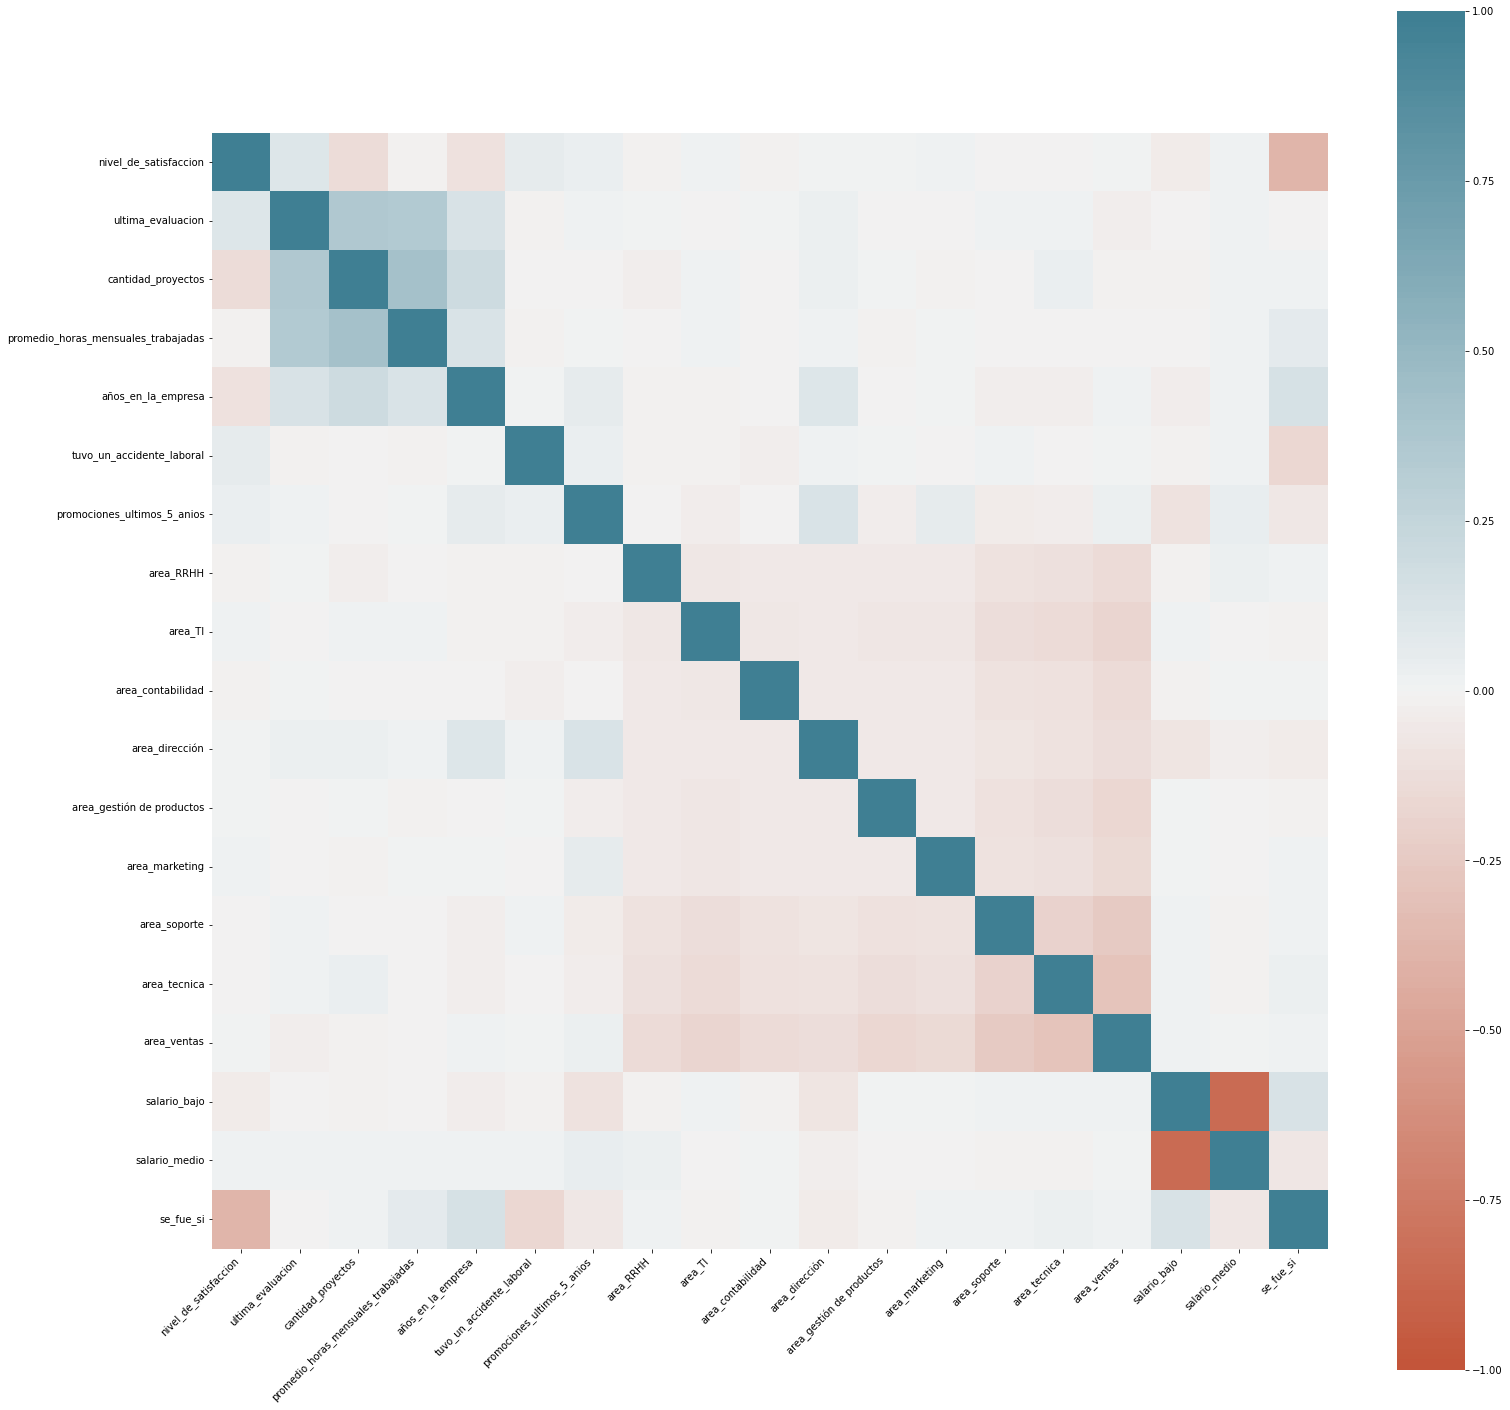

In [13]:
#Realizamos una matriz de correlacion para comprender la correlacion entre los datos. 
correlacion = df_train.corr()
plt.figure(figsize=(25,25))
ax = sns.heatmap(
    correlacion, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [14]:
# Seteamos nuestro target a predecir.
target='se_fue_si'

#Creamos la matriz de features "X" y dropeamos la columna de nuestro target.
X = df_train.drop(target,axis=1)

#Creamos la variable "y" que es la serie del target.
y = df_train[target]

#Visualizamos los objetos creamos y chequeamos que no haya errores.
print('Tamaño de "X":', X.shape)
print('Tamaño de "y":', y.shape)
if X.shape[0] != y.shape[0]:
  print("Las filas de X e y no coinciden, chequear dataset")

Tamaño de "X": (8000, 18)
Tamaño de "y": (8000,)


In [15]:
# Divido el conjunto de datos en entrenamiento y prueba.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5360, 18), (2640, 18), (5360,), (2640,))

Realizamos un pipeline + GridSearch para realizar un flujo de trabajo, donde vamos a seleccionar las features y vamos a aplicar el modelo de KNN.

In [16]:
# genero una clase que contenga al Data Transformer para seccionar las features

class FeatureSelection(BaseEstimator, TransformerMixin):

    def __init__(self,selected_features):
        self.selected_features = selected_features

    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        return X[self.selected_features]

In [17]:
# definimos el valor máximo de features a conservar utilizando RFE

n_features_to_select=1
estimator = LogisticRegression(solver='lbfgs', max_iter=1000)
rfe = RFE(estimator, n_features_to_select, step = 5)

rfe.fit(X, y)

scores = pd.DataFrame()
scores["Attribute Name"] = X.columns; scores["Ranking"] = rfe.ranking_; scores["Support"] = rfe.support_

scores= scores.sort_values('Ranking',ignore_index=True)

c:\Users\nanomanu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [18]:
#Averiguo los mejores score
scores["Attribute Name"].loc[0:5]

0          nivel_de_satisfaccion
1                   salario_bajo
2      tuvo_un_accidente_laboral
3                   area_tecnica
4                      area_RRHH
5    promociones_ultimos_5_anios
Name: Attribute Name, dtype: object

In [19]:
#Creo 4 listas para luego utilizarlos
cantidad_features= [3,7,11,17]
d={}
for i in cantidad_features:
    features= scores["Attribute Name"].loc[0:i].tolist()
    d["features_{0}".format(i)]=X[features].columns.values
d

{'features_3': array(['nivel_de_satisfaccion', 'salario_bajo',
        'tuvo_un_accidente_laboral', 'area_tecnica'], dtype=object),
 'features_7': array(['nivel_de_satisfaccion', 'salario_bajo',
        'tuvo_un_accidente_laboral', 'area_tecnica', 'area_RRHH',
        'promociones_ultimos_5_anios', 'salario_medio',
        'ultima_evaluacion'], dtype=object),
 'features_11': array(['nivel_de_satisfaccion', 'salario_bajo',
        'tuvo_un_accidente_laboral', 'area_tecnica', 'area_RRHH',
        'promociones_ultimos_5_anios', 'salario_medio',
        'ultima_evaluacion', 'cantidad_proyectos', 'area_marketing',
        'area_soporte', 'area_ventas'], dtype=object),
 'features_17': array(['nivel_de_satisfaccion', 'salario_bajo',
        'tuvo_un_accidente_laboral', 'area_tecnica', 'area_RRHH',
        'promociones_ultimos_5_anios', 'salario_medio',
        'ultima_evaluacion', 'cantidad_proyectos', 'area_marketing',
        'area_soporte', 'area_ventas', 'años_en_la_empresa',
        'pro

In [20]:
features_4 = d.get("features_3")
features_8 = d.get("features_7")
features_12 = d.get("features_11")
features_18 = d.get("features_17")

In [21]:
selector = FeatureSelection(selected_features=X[features].columns.values)

In [22]:
selector_4 = FeatureSelection(selected_features=X[features_4].columns.values)
selector_8 = FeatureSelection(selected_features=X[features_8].columns.values)
selector_12 = FeatureSelection(selected_features=X[features_12].columns.values)
selector_18 = FeatureSelection(selected_features=X[features_18].columns.values)

In [23]:
#creo la lista de pasos del pipeline. 

pasos= [('feature_engineering',selector),
        ('preprocesamiento',StandardScaler()),
        ('clasificador',KNeighborsClassifier())]

pipe_grid_final=Pipeline(pasos)

In [24]:
#Creo el grid search para poder evaluar distintas alternativas.

param_grid_final = [{'feature_engineering':[selector_4, selector_8, selector_12, selector_18, None],
                   'preprocesamiento':[StandardScaler(), MinMaxScaler(), None],
                   'clasificador__n_neighbors':range(2,8,1), 
                   'clasificador__weights':['uniform','distance']}]

folds=StratifiedKFold(n_splits=50, shuffle=True, random_state=42)

grid_final=GridSearchCV(pipe_grid_final, param_grid_final, cv=folds)

grid_final.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=50, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('feature_engineering',
                                        FeatureSelection(selected_features=array(['nivel_de_satisfaccion', 'salario_bajo',
       'tuvo_un_accidente_laboral', 'area_tecnica', 'area_RRHH',
       'promociones_ultimos_5_anios', 'salario_medio',
       'ultima_evaluacion', 'cantidad_proyectos', 'are...
       'tuvo_un_accidente_laboral', 'area_tecnica', 'area_RRHH',
       'promociones_ultimos_5_anios', 'salario_medio',
       'ultima_evaluacion', 'cantidad_proyectos', 'area_marketing',
       'area_soporte', 'area_ventas', 'años_en_la_empresa',
       'promedio_horas_mensuales_trabajadas', 'area_contabilidad',
       'area_dirección', 'area_gestión de productos', 'area_TI'],
      dtype=object)),
                                                  None],
                          'preprocesamiento': [StandardScaler(), MinMaxScaler(),
                  

In [25]:
#Imprimo el score del modelo y los mejores parametros
print('Score: ',grid_final.best_score_)
grid_final.best_estimator_

Score:  0.9527968155070959


Pipeline(steps=[('feature_engineering',
                 FeatureSelection(selected_features=array(['nivel_de_satisfaccion', 'salario_bajo',
       'tuvo_un_accidente_laboral', 'area_tecnica', 'area_RRHH',
       'promociones_ultimos_5_anios', 'salario_medio',
       'ultima_evaluacion', 'cantidad_proyectos', 'area_marketing',
       'area_soporte', 'area_ventas', 'años_en_la_empresa',
       'promedio_horas_mensuales_trabajadas', 'area_contabilidad',
       'area_dirección', 'area_gestión de productos', 'area_TI'],
      dtype=object))),
                ('preprocesamiento', StandardScaler()),
                ('clasificador',
                 KNeighborsClassifier(n_neighbors=2, weights='distance'))])

In [26]:
# Seteamos nuestro target a predecir.
target_test='se_fue'

#Elimino la columana target del test.
df_test = df_test.drop(target_test, axis=1)

# Convertimos las columnas categoricas.
df_test_dummies = pd.get_dummies(df_test[['area', 'salario']], drop_first=True)
df_test_dummies

,area_RRHH,area_TI,area_contabilidad,area_dirección,area_gestión de productos,area_marketing,area_soporte,area_tecnica,area_ventas,salario_bajo,salario_medio
0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,0,0,1,1,0
1996,0,0,0,0,0,1,0,0,0,1,0
1997,0,0,0,0,0,0,0,1,0,1,0
1998,0,0,0,0,0,0,0,0,1,1,0


In [27]:
#Concatenamos ambos dataset
df_test = pd.concat([df_test[columnas_numericas], df_test_dummies] ,axis=1)

In [28]:
#Predecimos con los datos de test para obtener nuestro resultado.
y_pred = grid_final.best_estimator_.predict(df_test)

#Creo un dataframe de los datos obtenidos
df_y_pred = pd.DataFrame(y_pred, columns = ["se_fue"])

#Paso la columna que esta con 0 y 1(dummies) a "SI" o "NO"
df_y_pred = df_y_pred['se_fue'].apply(lambda x: "Si" if (x == 1) else "No")
df_y_pred

0       Si
1       Si
2       No
3       No
4       No
        ..
1995    No
1996    Si
1997    Si
1998    No
1999    No
Name: se_fue, Length: 2000, dtype: object

In [29]:
#Creo el dataframe submission con el ID del test mas los resultados obtenidos. 
submission = pd.concat([ID_test, df_y_pred], axis=1)  
submission

,ID,se_fue
0,2,Si
1,4,Si
2,9,No
3,14,No
4,15,No
...,...,...
1995,9980,No
1996,9987,Si
1997,9991,Si
1998,9996,No


In [30]:
#Exporto el resultado en CSV.
ruta_exportar = r'C:/Users/nanomanu/Desktop/Evaluacion Tecnica Analista Sr - Consultor BDS/Entrega/'

submission.to_csv(r''+ ruta_exportar + 'Submission_Manuel_Nano.csv',index=False)